In [1]:
cd fastText_multilingual-master

/Users/christanasescu/fastText_multilingual-master


In [2]:
import numpy as np
#import FastVector

In [3]:
import scipy

In [4]:
import pybind11

In [5]:
class FastVector:
    """
    Minimal wrapper for fastvector embeddings.
    ```
    Usage:
        $ model = FastVector(vector_file='/path/to/wiki.en.vec')
        $ 'apple' in model
        > TRUE
        $ model['apple'].shape
        > (300,)
    ```
    """

    def __init__(self, vector_file='', transform=None):
        """Read in word vectors in fasttext format"""
        self.word2id = {}

        # Captures word order, for export() and translate methods
        self.id2word = []

        print('reading word vectors from %s' % vector_file)
        with open(vector_file, 'r') as f:
            (self.n_words, self.n_dim) = \
                (int(x) for x in f.readline().rstrip('\n').split(' '))
            self.embed = np.zeros((self.n_words, self.n_dim))
            for i, line in enumerate(f):
                elems = line.rstrip('\n').split(' ')
                self.word2id[elems[0]] = i
                self.embed[i] = elems[1:self.n_dim+1]
                self.id2word.append(elems[0])
        
        # Used in translate_inverted_softmax()
        self.softmax_denominators = None
        
        if transform is not None:
            print('Applying transformation to embedding')
            self.apply_transform(transform)

    def apply_transform(self, transform):
        """
        Apply the given transformation to the vector space
        Right-multiplies given transform with embeddings E:
            E = E * transform
        Transform can either be a string with a filename to a
        text file containing a ndarray (compat. with np.loadtxt)
        or a numpy ndarray.
        """
        transmat = np.loadtxt(transform) if isinstance(transform, str) else transform
        self.embed = np.matmul(self.embed, transmat)

    def export(self, outpath):
        """
        Transforming a large matrix of WordVectors is expensive. 
        This method lets you write the transformed matrix back to a file for future use
        :param The path to the output file to be written 
        """
        fout = open(outpath, "w")

        # Header takes the guesswork out of loading by recording how many lines, vector dims
        fout.write(str(self.n_words) + " " + str(self.n_dim) + "\n")
        for token in self.id2word:
            vector_components = ["%.6f" % number for number in self[token]]
            vector_as_string = " ".join(vector_components)

            out_line = token + " " + vector_as_string + "\n"
            fout.write(out_line)

        fout.close()

    def translate_nearest_neighbour(self, source_vector):
        """Obtain translation of source_vector using nearest neighbour retrieval"""
        similarity_vector = np.matmul(FastVector.normalised(self.embed), source_vector)
        target_id = np.argmax(similarity_vector)
        return self.id2word[target_id]

    def translate_inverted_softmax(self, source_vector, source_space, nsamples,
                                   beta=10., batch_size=100, recalculate=True):
        """
        Obtain translation of source_vector using sampled inverted softmax retrieval
        with inverse temperature beta.
        nsamples vectors are drawn from source_space in batches of batch_size
        to calculate the inverted softmax denominators.
        Denominators from previous call are reused if recalculate=False. This saves
        time if multiple words are translated from the same source language.
        """
        embed_normalised = FastVector.normalised(self.embed)
        # calculate contributions to softmax denominators in batches
        # to save memory
        if self.softmax_denominators is None or recalculate is True:
            self.softmax_denominators = np.zeros(self.embed.shape[0])
            while nsamples > 0:
                # get batch of randomly sampled vectors from source space
                sample_vectors = source_space.get_samples(min(nsamples, batch_size))
                # calculate cosine similarities between sampled vectors and
                # all vectors in the target space
                sample_similarities = \
                    np.matmul(embed_normalised,
                              FastVector.normalised(sample_vectors).transpose())
                # accumulate contribution to denominators
                self.softmax_denominators \
                    += np.sum(np.exp(beta * sample_similarities), axis=1)
                nsamples -= batch_size
        # cosine similarities between source_vector and all target vectors
        similarity_vector = np.matmul(embed_normalised,
                                      source_vector/np.linalg.norm(source_vector))
        # exponentiate and normalise with denominators to obtain inverted softmax
        softmax_scores = np.exp(beta * similarity_vector) / \
                         self.softmax_denominators
        # pick highest score as translation
        target_id = np.argmax(softmax_scores)
        return self.id2word[target_id]

    def get_samples(self, nsamples):
        """Return a matrix of nsamples randomly sampled vectors from embed"""
        sample_ids = np.random.choice(self.embed.shape[0], nsamples, replace=False)
        return self.embed[sample_ids]

    @classmethod
    def normalised(cls, mat, axis=-1, order=2):
        """Utility function to normalise the rows of a numpy array."""
        norm = np.linalg.norm(
            mat, axis=axis, ord=order, keepdims=True)
        norm[norm == 0] = 1
        return mat / norm
    
    @classmethod
    def cosine_similarity(cls, vec_a, vec_b):
        """Compute cosine similarity between vec_a and vec_b"""
        return np.dot(vec_a, vec_b) / \
            (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

    def __contains__(self, key):
        return key in self.word2id

    def __getitem__(self, key):
        return self.embed[self.word2id[key]]

In [6]:
#import numpy as np
#from fasttext import FastVector

# from https://stackoverflow.com/questions/21030391/how-to-normalize-array-numpy
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    """
    Source and target dictionaries are the FastVector objects of
    source/target languages. bilingual_dictionary is a list of 
    translation pair tuples [(source_word, target_word), ...].
    """
    source_matrix = []
    target_matrix = []

    for (source, target) in bilingual_dictionary:
        if source in source_dictionary and target in target_dictionary:
            source_matrix.append(source_dictionary[source])
            target_matrix.append(target_dictionary[target])

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

# We create dictionaries for both languages based off of the FastText Wiki vectors for each language: 

In [7]:

ro_dictionary = FastVector(vector_file='cc.ro.300.vec')
en_dictionary = FastVector(vector_file='wiki.en.vec')

reading word vectors from cc.ro.300.vec
reading word vectors from wiki.en.vec


# We create a bilingual dictionary based on overlappings between the two languages:

In [8]:
ro_words = set(ro_dictionary.word2id.keys())
en_words = set(en_dictionary.word2id.keys())
overlap = list(en_words & ro_words)
bilingual_dictionary = [(entry, entry) for entry in overlap]

In [9]:
# form the training matrices
source_matrix, target_matrix = make_training_matrices(
    ro_dictionary, en_dictionary, bilingual_dictionary)

# We align the EN dictionary with the RO one:

In [10]:
# learn and apply the transformation
transform = learn_transformation(source_matrix, target_matrix)
en_dictionary.apply_transform(transform)

In [11]:
en_words = set(en_dictionary.word2id.keys())

In [12]:

import re
import numpy as np
import pandas as pd
from pprint import pprint
from nltk.tokenize import sent_tokenize, word_tokenize
import os
#The OS module in Python provides a way of using operating system dependent functionality. 
#The functions that the OS module provides allows you to interface with the underlying operating system 
#that Python is running on – be that Windows, Mac or Linux.

from os import listdir
from os.path import isfile, join

# Gensim
import gensim
import gensim.corpora as corpora
from gensim import models, corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [13]:
import nltk as nltk 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christanasescu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#stopwords = nltk.corpus.stopwords.words("stopwords_Latin.txt")

In [14]:
def tokenize(text):
    tokens = word_tokenize(text)
    tokens = _pre_clean(tokens)
    tokens = [token for token in tokens if len(token) > 0]
    tokens = [token for token in tokens if token not in stopwords]
    #tokens = [get_lemma(token) for token in tokens]
    return tokens

In [15]:
def _pre_clean(list_of_text):
        '''
        preliminary cleaning of the text
        - remove new line character i.e. \n or \r
        - remove tabs i.e. \t
        - remove extra spaces
        '''
        cleaned_list = []
        for text in list_of_text:
            # print("original:", text)
            text = text.replace('\\n', ' ')
            text = text.replace('\\r', ' ')
            text = text.replace('\\t', ' ')
            pattern = re.compile(r'\s+')
            text = re.sub(pattern, ' ', text)
            text = text.strip()
            text = text.lower()
            # check for empty strings
            if text != '' and text is not None:
                cleaned_list.append(text)

        return cleaned_list

In [16]:

stopwords = nltk.corpus.stopwords.words('stop_words_poetry.txt')

stopwords.append('...')
stopwords.append("'d")
stopwords.append('...')
stopwords.append("&")
stopwords.append("upon")
stopwords.append("also")
stopwords.append("hath")
stopwords.append("must")
stopwords.append("therefore")
stopwords.append("doth")
stopwords.append("could")
stopwords.append("would")
stopwords.append("another")
stopwords.append("much")
#stopwords.append("give")
stopwords.append("like")
stopwords.append("since")
#stopwords.append("many")
stopwords.append("without")
#stopwords.append("first")
stopwords.append("though")
#stopwords.append("well")
stopwords.append("often")
#stopwords.append("great")
stopwords.append("either")
stopwords.append("even")
stopwords.append("shall")
#stopwords.append("they")
stopwords.append("what")
stopwords.append("their")
#stopwords.append("more")
#stopwords.append("there")
#stopwords.append("your")
stopwords.append("them")

In [17]:
stopwords.extend(['a', 'like', 'you', 'they', 'he', 'be', 'it', 'your', 'her', 'of', 'more', 'there', 'no', 'not', '’', 'what', 'my', 'his', 'she', 'to', 'our', 'me', 'we', 'in', 'can', 'us', 'an', 'if', 'do', 'this', '”', 'because', 'who', 'hand', 'but', 'him'])

In [15]:
cd fastText_multilingual-master

/Users/christanasescu/fastText_multilingual-master


In [162]:
cd ..

/Users/christanasescu/fastText_multilingual-master


# We open, label, and tokenize all EN poems:

In [18]:
HOME = os.getcwd()

TEXTS_DIR = HOME + "/google_search_en/"

filelabels_en = {}

texts_data = []

files = [f for f in os.listdir(TEXTS_DIR) if os.path.isfile(os.path.join(TEXTS_DIR, f))]

import string
from string import punctuation

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))

tokens_total = []

count = -1
 
os.chdir(TEXTS_DIR)
    
for f in files:
    #os.chdir(TEXTS_DIR)
    with open(f, "r", encoding='utf-8', errors = 'ignore') as openf:
        tokens = []
        count = count + 1
        filelabels_en[count] = os.path.basename(openf.name)
        for line in openf:
            sent_text = nltk.sent_tokenize(line)
            for sentence in sent_text:
                tokens1 = tokenize(sentence)
                tokens1 = [item.translate(remove_punct_map)
                      for item in tokens1]
                #filter_object = filter(lambda x: x != "", tokens1)
                tokens1 = [x for x in tokens1 if x!= ""]
                tokens1 = [x.lower() for x in tokens1]
                for token in tokens1:
                    tokens.append(token)
                    tokens_total.append(token)
                #if random.random() > .99:
                #print(tokens)
    #print(tokens_total)
    texts_data.append(tokens)

print(filelabels_en)

{0: '0_recycled_poems.txt', 1: '10_recycling_in_knoxville.txt', 2: '11_san_jose.txt', 3: '12_pandemic_pop_nostalgia.txt', 4: '13_interfaith.txt', 5: '14_peace_sign.txt', 6: '15_bidart.txt', 7: '16_poems_about_anything.txt', 8: '17_ancient_mariner_pandemic_436.txt', 9: '18_jay_horjo.txt', 10: '19_recycled_medals.txt', 11: '1_lockdown_poems.txt', 12: '20_sumita.txt', 13: '21_cambodian_poet.txt', 14: '22_cousteau_and_proverbs.txt', 15: '23_denise_duhamel.txt', 16: '2_hybrid_work_revolution.txt', 17: '3_classes_and_workshops.txt', 18: '4_birdcalls.txt', 19: '5_climate_change_across_political_divide.txt', 20: '6_racial_equity.txt', 21: '7_netflix_dahl.txt', 22: '8_hide_identity_w_one_click.txt', 23: '9_plastic_protector_or_polluter.txt'}


In [19]:
filelabels1 = list(filelabels_en)

In [ ]:

#pwd

In [20]:
for i in range(len(filelabels1)):
    texts_data[i] = [x for x in texts_data[i] if x not in stopwords]

In [ ]:
#vect_en = []

In [21]:
def l2_norm(x):
   return np.sqrt(np.sum(x**2))

def div_norm(x):
   norm_value = l2_norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x

In [ ]:
# WE HAVE TO CONVERT EN_WORDS & FR_WORDS TO LISTS (BEFORE RUNNING THE CELLS BELOW) otherwise the code below is not reliable

In [22]:
en_words = list(en_words)
ro_words = list(ro_words)

In [ ]:

# Just checking, you don't have to run this one, might jam up your notebook (it's a lot to print out)
for j in range(len(texts_data[1])):
    if texts_data[1][j] in en_words:
        print(div_norm(la_dictionary[texts_data[1][j]]))
    else:
        continue

# We generate vectors for all EN poems:

In [23]:
vect_en = []

for i in range(len(filelabels1)):
        vect1 = []
        for j in range(len(texts_data[i])):
            if texts_data[i][j] in en_words:
                vect1.append(div_norm(en_dictionary[texts_data[i][j]]))
            else:
                continue
        vect0 = sum(vect1) / len(texts_data[i])
        vect_en.append(vect0)

In [24]:

len(vect_en)

24

In [ ]:
#print(vect_en[21])

In [24]:

cd ..

/Users/christanasescu/fastText_multilingual-master


In [25]:

HOME = os.getcwd()

In [ ]:
pwd

# We move on to the RO subcorpus:

In [26]:

TEXTS_DIR = HOME + "/various_wanted_ro/"

In [27]:

stopwords = nltk.corpus.stopwords.words("romanian_1.txt")

In [156]:
len(filelabels1)

24

In [28]:
filelabels_ro = {}

texts_data = []

files = [f for f in os.listdir(TEXTS_DIR) if os.path.isfile(os.path.join(TEXTS_DIR, f))]

import string
from string import punctuation

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))

tokens_total = []

count = len(filelabels1) - 1
 
os.chdir(TEXTS_DIR)
    
for f in files:
    #os.chdir(TEXTS_DIR)
    if count <= 300:
        with open(f, "r", encoding='utf-8', errors = 'ignore') as openf:
            tokens = []
            count = count + 1
            filelabels_ro[count] = os.path.basename(openf.name)
            for line in openf:
                sent_text = nltk.sent_tokenize(line)
                for sentence in sent_text:
                    tokens1 = tokenize(sentence)
                    tokens1 = [item.translate(remove_punct_map)
                      for item in tokens1]
                #filter_object = filter(lambda x: x != "", tokens1)
                    tokens1 = [x for x in tokens1 if x!= ""]
                    for token in tokens1:
                        tokens.append(token)
                        tokens_total.append(token)
                #if random.random() > .99:
                #print(tokens)
    #print(tokens_total)
        texts_data.append(tokens)

print(filelabels_ro)

{24: '0_nota_traducere.txt', 25: '10_imperialism_cultural.txt', 26: '11_eminescu_dot_com.txt', 27: '12_dezintoxicare_renovare.txt', 28: '13_jumate_ingrozit_jumate_bucuros.txt', 29: '14_gol_plin.txt', 30: '15_inghitind_teorii.txt', 31: '16_conferinta_spiritu.txt', 32: '17_fatzete_cuprinzatoare.txt', 33: '18_enervant_incompetent.txt', 34: '19_marirea_de_corpus.txt', 35: '1_nota_forma_poetica.txt', 36: '20_la_nesfarsit_bucuria_complexitatii.txt', 37: '21_s-ar_putea_traduce.txt', 38: '22_ori_si-o_trag_in_cur.txt', 39: '23_de_poiesis.txt', 40: '2_ecolalia.txt', 41: '3_poetique_curieuse.txt', 42: '4_recunoaste_altul.txt', 43: '5_ton_colectiv.txt', 44: '6_privitor_la_teatru.txt', 45: '7_asta_nu_e_arta.txt', 46: '8_99.txt', 47: '9_paralele_se_intersecteaza.txt'}


In [33]:
len(texts_data)

24

In [29]:

filelabels2 = list(filelabels_ro)

In [30]:

for i in range(24):
    texts_data[i] = [x for x in texts_data[i] if x not in stopwords]

# We generate vectors representing every single RO poem:

In [31]:
vect_ro = []

for i in range(24):
        vect1 = []
        for j in range(len(texts_data[i])):
            if texts_data[i][j] in ro_words:
                vect1.append(div_norm(ro_dictionary[texts_data[i][j]]))
            else:
                continue
        vect0 = sum(vect1) / len(texts_data[i])
        vect_ro.append(vect0)

In [37]:

len(vect_ro)

24

# We consolidate EN and RO vectors into one single list:

In [32]:

vect_total = [*vect_en, *vect_ro]

In [33]:

len(vect_total)

48

In [ ]:
# We create a list of all labels as well, EN & FR together:

In [42]:

#labels = filelabels1 + filelabels2

labels = [*filelabels1, *filelabels2]

In [41]:
len(labels)

48

In [34]:

dt = [('correlation', float)]

In [35]:

vect_mat = np.mat(vect_total)

# We calculate the matrix of similiarities between all vectors, EN & RO. Then we generate the network representing that matrix: the nodes are all EN & RO poem-vectors and the edges represent the similarities between every two nodes:

In [36]:

similarity_matrix = np.matrix((vect_mat * vect_mat.T).A, dtype=dt)

In [37]:

import networkx as nx

G = nx.from_numpy_matrix(similarity_matrix)

weights = [(G[tpl[0]][tpl[1]]['correlation']) for tpl in G.edges()]

In [38]:

e = [(x, x) for x in G.nodes()] 
G.remove_edges_from(e)

In [39]:
def draw_graph(G):
    weights = [(G[tpl[0]][tpl[1]]['correlation']) for tpl in G.edges()]
    normalized_weights = [400*weight/sum(weights) for weight in weights]
    fig, ax = plt.subplots(figsize=(25, 16))
    pos=nx.spring_layout(G)
    labels1 = dict([x for x in enumerate(labels)])
    #labels=labels
    nx.draw_networkx(
        G,
        pos,
        edges=G.edges(),
        width=normalized_weights,
        labels=labels1,
        with_labels=True,
        node_size=800,
        node_color='r',
        alpha=1,
        font_color = 'w',
        font_size=20
    )
    #plt.show()
    return

In [40]:
import matplotlib.pyplot as plt

/Users/christanasescu/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


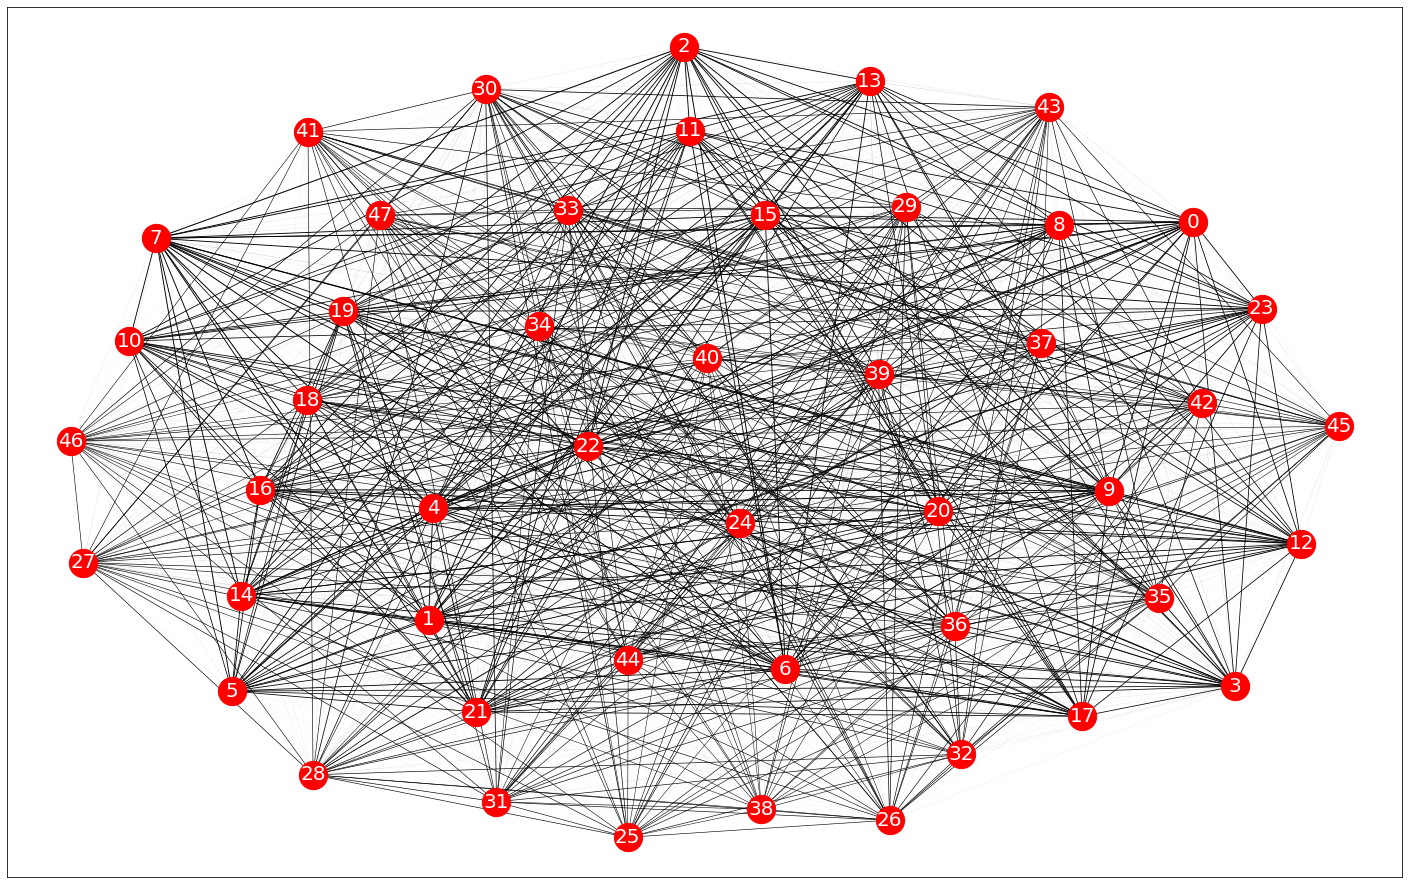

In [43]:
draw_graph(G) # Here is our bilingual corpus

# This is our bilingual English and Romanian corpus; the nodes are the poems represented as correlated vectors based off of the wiki multilingual word embeddings that we aligned in FastText. 

In [50]:

len(list(G.nodes))

48

In [44]:

len(list(G.edges))

1128

In [45]:

weights = [(tpl,(G[tpl[0]][tpl[1]]['correlation'])) for tpl in G.edges()]

# We sort the edges in the decreasing order of similarities between the poem-nodes they connect:

In [46]:

Sorted_weights = sorted(weights, key = lambda t: t[1], reverse = True)

In [47]:
print(Sorted_weights[0]) # the strongest correlation

((2, 7), 0.19748760196224058)


In [48]:

print(Sorted_weights[(len(Sorted_weights)-1)]) # the weakest correlation

((8, 32), -0.005894323844115798)


In [ ]:

#VECTORS AND FILE LABELS NEED BE SWITCED TO EN & RO

In [50]:

filelabels_en[2]

'11_san_jose.txt'

In [58]:

filelabels_en[8]

'17_ancient_mariner_pandemic_436.txt'

In [59]:
filelabels_ro[32]

'17_fatzete_cuprinzatoare.txt'

In [52]:

filelabels_total = {}

In [53]:
filelabels_total.update(filelabels_en)

In [54]:
filelabels_total.update(filelabels_ro)

In [55]:

Degrees = G.degree(weight = "correlation")
Sorted_degrees = sorted(Degrees, key = lambda t: t[1], reverse = True)

In [56]:

Sorted_degrees[0] #node with the highest degree

(7, 4.152342940943676)

In [60]:
Sorted_degrees[len(Sorted_degrees)-1] #node with the lowest degree

(34, 2.1296687912526537)

In [75]:

#print(filelabels_total)

In [61]:
print(Sorted_degrees)

[(7, 4.152342940943676), (6, 4.067529965913038), (4, 4.0152705219339815), (2, 3.9964492582059887), (9, 3.906473328287085), (1, 3.8266719775071767), (12, 3.7868209994780275), (22, 3.7663561454902297), (19, 3.757854613259522), (0, 3.750671402872434), (16, 3.7122018540264823), (14, 3.7119725440851963), (21, 3.6793186400392472), (13, 3.675539157860112), (11, 3.6640455758445647), (3, 3.6479154578884097), (23, 3.628901892718976), (5, 3.6178321600233345), (15, 3.590492053560409), (17, 3.499108479008037), (10, 3.3988512220458524), (8, 3.371342408823349), (20, 3.353556137893786), (30, 3.2421301636514), (18, 3.1254106753488875), (39, 3.0209271199087255), (43, 2.9656595096094662), (33, 2.943827678154465), (28, 2.880567893303415), (29, 2.877942035859449), (42, 2.8763329755226588), (35, 2.848669657503064), (27, 2.839775707423976), (31, 2.815767606468177), (26, 2.771183654055239), (45, 2.7493686828594335), (32, 2.7249361879253726), (46, 2.7024679972577967), (36, 2.6889553423931183), (47, 2.592949053

In [62]:

clo_cen = nx.closeness_centrality(G)
import operator
c = sorted(clo_cen.items(), key=operator.itemgetter(1), reverse=True)
print("Closeness centralities for G:", c)

Closeness centralities for G: [(0, 1.0), (1, 1.0), (2, 1.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 1.0), (25, 1.0), (26, 1.0), (27, 1.0), (28, 1.0), (29, 1.0), (30, 1.0), (31, 1.0), (32, 1.0), (33, 1.0), (34, 1.0), (35, 1.0), (36, 1.0), (37, 1.0), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 1.0), (43, 1.0), (44, 1.0), (45, 1.0), (46, 1.0), (47, 1.0)]


In [65]:
# Weighted Closeness Centrality:
#clo_cen_w = nx.closeness_centrality(G, distance = 'correlation')
#c_w = sorted(clo_cen_w.items(), key=operator.itemgetter(1), reverse=True)
#print("Weighted closeness centralities for G in decreasing order", c_w)

In [66]:
#Betweeness centrality
bet_cen = nx.betweenness_centrality(G, weight = "correlation")
bet = sorted(bet_cen.items(), key=operator.itemgetter(1), reverse=True)
print("Betweenness centralities for G in decreasing order:", bet)

Betweenness centralities for G in decreasing order: [(44, 0.9634597594819612), (10, 0.9597594819611471), (34, 0.9329324699352451), (9, 0.9209065679925995), (4, 0.9116558741905644), (32, 0.9014801110083257), (41, 0.893154486586494), (8, 0.8811285846438484), (17, 0.8126734505087881), (15, 0.7664199814986125), (25, 0.7608695652173914), (37, 0.7562442183163738), (24, 0.7553191489361702), (29, 0.7520814061054579), (16, 0.7294172062904718), (7, 0.6521739130434783), (40, 0.6221091581868641), (20, 0.4162812210915819), (23, 0.29463459759481964), (5, 0.09343200740055504), (38, 0.08926919518963923), (31, 0.011563367252543942), (0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (6, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (18, 0.0), (19, 0.0), (21, 0.0), (22, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (30, 0.0), (33, 0.0), (35, 0.0), (36, 0.0), (39, 0.0), (42, 0.0), (43, 0.0), (45, 0.0), (46, 0.0), (47, 0.0)]


In [72]:
#Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G, weight = "correlation")
eigenvector = sorted(eigenvector_centrality.items(), key=operator.itemgetter(1), reverse=True)
print("Eigenvector centralities for G in decreasing order:", eigenvector)

Eigenvector centralities for G in decreasing order: [(12, 0.17436923434759055), (6, 0.17356516326519994), (7, 0.16623684344781223), (5, 0.1661378156199092), (8, 0.16449812098200864), (20, 0.16397141579015315), (2, 0.16373296823222014), (15, 0.16266821585453153), (23, 0.1624603120095704), (21, 0.16025795034162618), (3, 0.16022445515374356), (18, 0.15987258916761685), (10, 0.15765360498071657), (4, 0.1575348371057125), (19, 0.15629854745559696), (1, 0.15599035718704932), (22, 0.1543175697490334), (11, 0.15263408851654145), (17, 0.1517544618067747), (0, 0.15097283434833314), (14, 0.1490744859468935), (16, 0.1469761736397058), (13, 0.14318356052152056), (29, 0.1431365187284923), (28, 0.1402511835347314), (26, 0.1376016219399266), (33, 0.13425429860294294), (30, 0.13296138320862988), (42, 0.13215714156294245), (36, 0.1320908339899389), (46, 0.13156735423664326), (32, 0.13149344616476602), (34, 0.1314857188292962), (9, 0.13146856745849658), (35, 0.13085599892618668), (24, 0.1308295491482456)

In [ ]:

#dag_longest_path(G, weight = "correlation")

In [ ]:

# len(filelabels_total)

In [116]:
# len(filelabels_en)

200

In [117]:
# len(filelabels_ro)

100

In [73]:

filelabels_ro

{24: '0_liceu_poezie_pandemie_razvan_chiorean.txt',
 25: '1_infatisarea_diavolului_lucia_terzea_ofrim.txt',
 26: '2_reciclarea_pe_intelesul_copiilor.txt',
 27: '3_poezie_saracie_pandemie_galaicu-paun.txt',
 28: '4_reciclare_creativa.txt',
 29: '5_cluj_spoken_word.txt',
 30: '6_sedinta_parlament_post-pandemie.txt',
 31: '7_adevarul_ro.txt',
 32: '8_olivia_ignatescu_director_stirbey.txt',
 33: '9_varia.txt',
 34: 'varia_1.txt',
 35: 'varia_10.txt',
 36: 'varia_11.txt',
 37: 'varia_12.txt',
 38: 'varia_13.txt',
 39: 'varia_14.txt',
 40: 'varia_2.txt',
 41: 'varia_3.txt',
 42: 'varia_4.txt',
 43: 'varia_5.txt',
 44: 'varia_6.txt',
 45: 'varia_7.txt',
 46: 'varia_8.txt',
 47: 'varia_9.txt'}

In [74]:
# filelabels_total

In [67]:

E = list(G.edges)

In [68]:

weights_list = [(e, (G[e[0]][e[1]]['correlation'])) for e in E]

# We are trying to find a route that would alternate between EN & RO poems in the decreasing order of similarity (i.e., weight of connecting edges) without crossing the same node (i.e., poem) twice:

Here are all the edges connecting EN to RO poems:

In [69]:

weights_en_to_ro = [(e, (G[e[0]][e[1]]['correlation'])) for e in E if e[0] in filelabels_en and e[1] in filelabels_ro]

In [70]:

weights_en_to_ro[0]

((0, 24), -0.000227047942713939)

In [71]:

len(weights_en_to_ro)

576

In [72]:

Sorted_weights_en_to_ro = sorted(weights_en_to_ro, key = lambda t: t[1], reverse = True)

In [73]:

Sorted_weights_en_to_ro[0] # The strongest EN-RO correlation

((6, 42), 0.014651735501494081)

In [74]:
filelabels_total[6]

'15_bidart.txt'

In [75]:
filelabels_total[42]

'4_recunoaste_altul.txt'

In [76]:

List_poem_itinerary = []

In [77]:



List_poem_itinerary.extend([(6, filelabels_total[6]), (42, filelabels_total[42])])

In [94]:

len(List_poem_itinerary)

2

# Let us identify the poem-nodes on such a route and the order in which they need to be crossed:

In [78]:

List_poem_itinerary = []
List_poem_itinerary.extend([(6, filelabels_total[6]), (42, filelabels_total[42])])

i = List_poem_itinerary[(len(List_poem_itinerary) - 1)][0]

while len(List_poem_itinerary) <= len(filelabels_total):
    if i < 24:
        weights_to_ro = []
        weights_to_ro = [e for e in Sorted_weights_en_to_ro if e[0][0]==i]
        for j in range(1, len(weights_to_ro)):
            if (weights_to_ro[j][0][1], filelabels_total[weights_to_ro[j][0][1]]) not in List_poem_itinerary:
                List_poem_itinerary.append((weights_to_ro[j][0][1], filelabels_total[weights_to_ro[j][0][1]]))
                i = weights_to_ro[j][0][1]
                break
        else:
            break
    else:
        weights_to_en = []
        weights_to_en = [e for e in Sorted_weights_en_to_ro if e[0][1]==i]
        for k in range(1, len(weights_to_en)): 
            if (weights_to_en[k][0][0], filelabels_total[weights_to_en[k][0][0]]) not in List_poem_itinerary:
                List_poem_itinerary.append((weights_to_en[k][0][0], filelabels_total[weights_to_en[k][0][0]]))
                i = weights_to_en[k][0][0]
                break
        else:
            break

# This is our EN-RO alternating route:

In [79]:
print(List_poem_itinerary)

[(6, '15_bidart.txt'), (42, '4_recunoaste_altul.txt'), (13, '21_cambodian_poet.txt'), (27, '12_dezintoxicare_renovare.txt'), (3, '12_pandemic_pop_nostalgia.txt'), (46, '8_99.txt'), (21, '7_netflix_dahl.txt'), (28, '13_jumate_ingrozit_jumate_bucuros.txt'), (1, '10_recycling_in_knoxville.txt'), (33, '18_enervant_incompetent.txt'), (22, '8_hide_identity_w_one_click.txt'), (43, '5_ton_colectiv.txt'), (14, '22_cousteau_and_proverbs.txt'), (39, '23_de_poiesis.txt'), (11, '1_lockdown_poems.txt'), (45, '7_asta_nu_e_arta.txt'), (2, '11_san_jose.txt'), (30, '15_inghitind_teorii.txt'), (0, '0_recycled_poems.txt'), (26, '11_eminescu_dot_com.txt'), (12, '20_sumita.txt'), (35, '1_nota_forma_poetica.txt'), (19, '5_climate_change_across_political_divide.txt'), (31, '16_conferinta_spiritu.txt'), (18, '4_birdcalls.txt'), (47, '9_paralele_se_intersecteaza.txt'), (7, '16_poems_about_anything.txt'), (38, '22_ori_si-o_trag_in_cur.txt'), (5, '14_peace_sign.txt'), (36, '20_la_nesfarsit_bucuria_complexitatii.t

In [91]:
len(List_poem_itinerary)

48

In [80]:
Itinerary_names = []

In [81]:
for i in range(len(List_poem_itinerary)):
    Itinerary_names.append(List_poem_itinerary[i][1])

In [82]:
print(Itinerary_names)

['15_bidart.txt', '4_recunoaste_altul.txt', '21_cambodian_poet.txt', '12_dezintoxicare_renovare.txt', '12_pandemic_pop_nostalgia.txt', '8_99.txt', '7_netflix_dahl.txt', '13_jumate_ingrozit_jumate_bucuros.txt', '10_recycling_in_knoxville.txt', '18_enervant_incompetent.txt', '8_hide_identity_w_one_click.txt', '5_ton_colectiv.txt', '22_cousteau_and_proverbs.txt', '23_de_poiesis.txt', '1_lockdown_poems.txt', '7_asta_nu_e_arta.txt', '11_san_jose.txt', '15_inghitind_teorii.txt', '0_recycled_poems.txt', '11_eminescu_dot_com.txt', '20_sumita.txt', '1_nota_forma_poetica.txt', '5_climate_change_across_political_divide.txt', '16_conferinta_spiritu.txt', '4_birdcalls.txt', '9_paralele_se_intersecteaza.txt', '16_poems_about_anything.txt', '22_ori_si-o_trag_in_cur.txt', '14_peace_sign.txt', '20_la_nesfarsit_bucuria_complexitatii.txt', '23_denise_duhamel.txt', '0_nota_traducere.txt', '9_plastic_protector_or_polluter.txt', '21_s-ar_putea_traduce.txt', '19_recycled_medals.txt', '2_ecolalia.txt', '2_hyb

# We are looking for a line in each of these poems along our route--stronger to weaker cross-language links, to the least aligned--a line best representing the poem vector-prosody-wise, that is, a line whose vector has the greatest cosine similarity to the vector of the poem as a whole

In [83]:
pwd

'/Users/christanasescu/fastText_multilingual-master/various_wanted_ro'

In [84]:

cd ..

/Users/christanasescu/fastText_multilingual-master


# We need to move all--and only--the poems on our route into a new directory. We start with the EN ones and then do the same with the RO poems on the route.

In this case it is actually all the poems in both folders.

In [85]:
import shutil 
import os 
import logging

In [86]:
HOME = os.getcwd()

In [87]:
source = HOME + "/various_wanted_ro/"

In [88]:
destination = HOME + "/two_walls_and_a_mirror_ro_&_en_itinerary/"

In [89]:
files = os.listdir(source)

In [90]:
for f in files:
    if f in Itinerary_names:
        shutil.move(source+f, destination)

Now the EN ones:

In [91]:

source = HOME + "/google_search_en/"

In [92]:
files = os.listdir(source)

In [93]:
for f in files:
    if f in Itinerary_names:
        shutil.move(source+f, destination)

# Now that we got all the poems needed into one directory, we convert each of them into a list of lines (in which every element is a line in that specific poem) and consolidate these lists into a list of lists whose order of elements is the one of the destinations on our route:

In [111]:

HOME = os.getcwd()

Poems_Dir = HOME + "/two_walls_and_a_mirror_ro_&_en_itinerary/"
#Poems_Dir = HOME

os.chdir(Poems_Dir)
lines = [i for i in range(len(Itinerary_names))]

for i in range(len(List_poem_itinerary)):
    lines_1 = []
    with open (List_poem_itinerary[i][1], 'rt') as file:
        for line in file:
                line = line.replace('\\n', ' ')
                line = line.replace('\\r', ' ')
                line = line.replace('\\t', ' ')
                pattern = re.compile(r'\s+')
                line = re.sub(pattern, ' ', line)
                line = line.strip()
                line = line.lower()
                # check for empty strings
                if line != '' and line is not None:
                    lines_1.append(line)
        lines[i] = lines_1
    
    
    

        

In [95]:

lines[0]

['christopher spaide: "on frank bidart" - the yale review',
 'a review of half-light: collected poems, 1965–2016 : " bidart\'s tendency ... recycle phrases, imply arguments over arrangements of poems',
 'as we all save ourselves from the pandemic by social distancing tiktok / crafters have been saving the trees from deforestation by recycling paper',
 'it was created for a runway show that was cancelled due to the pandemic / i really enjoy the challenge of trying to get diverse materials to join and fit']

In [96]:
List_poem_itinerary[0]

(6, '15_bidart.txt')

In [97]:
poems_tokens = []

In [98]:

for line in lines:
    poems_tokens.append(line)

# Or poems_tokens.extend(lines)

In [99]:

import copy

#poems_tokens = copy.copy(lines)

In [82]:

# Let's make sure they are not one and the same object:

poems_tokens is lines

False

In [83]:
lines[1]

['forum liber - întrebați și discutați cu romania orice',
 'our lord and savior lenghel, imi place sa mananc, compune poezii despre ... / load of medical equipment to help tunisia fight the covid pandemic',
 'poezie la metafizică experimentală / drd. ... de reciclare a hârtiei şi cartonului / drd',
 'la uvt, - revista orizont http://www.revistaorizont.ro › arhiva › august2021 pdf',
 'scheletele poeziei, aşa că nu vă voi da în ... / adunat textele puse acolo în vreme de pandemie într-un volum al cărui titlu are']


We tokenize the lines of each poem separately and thus convert the lines into lists of tokens:

In [100]:

for i in range(len(lines)):
    for j in range(len(lines[i])):
        tokens = []
        tokens1 = tokenize(lines[i][j])
        tokens1 = [item.translate(remove_punct_map)
                      for item in tokens1 if item != "/"]
        tokens1 = [x for x in tokens1 if x!= ""]
        for token in tokens1:
                    tokens.append(token)
        poems_tokens[i][j] = tokens


In [101]:

poems_tokens[0]

[['christopher', 'spaide', 'on', 'frank', 'bidart', 'the', 'yale', 'review'],
 ['review',
  'of',
  'halflight',
  'collected',
  'poems',
  '1965–2016',
  'bidart',
  's',
  'tendency',
  'recycle',
  'phrases',
  'imply',
  'arguments',
  'over',
  'arrangements',
  'of',
  'poems'],
 ['we',
  'all',
  'save',
  'ourselves',
  'from',
  'the',
  'pandemic',
  'by',
  'social',
  'distancing',
  'tiktok',
  'crafters',
  'have',
  'been',
  'saving',
  'the',
  'trees',
  'from',
  'deforestation',
  'by',
  'recycling',
  'paper'],
 ['it',
  'was',
  'created',
  'for',
  'runway',
  'show',
  'that',
  'was',
  'cancelled',
  'due',
  'to',
  'the',
  'pandemic',
  'really',
  'enjoy',
  'the',
  'challenge',
  'of',
  'trying',
  'to',
  'get',
  'diverse',
  'materials',
  'to',
  'join',
  'and',
  'fit']]

In [102]:

stopwords_0 = nltk.corpus.stopwords.words('stop_words_poetry.txt')

In [103]:

for i in range(len(poems_tokens)):
    if i % 2 == 0:
        for j in range(len(poems_tokens[i])):
            poems_tokens[i][j] = [x for x in poems_tokens[i][j] if x not in stopwords_0]
    else:
        for j in range(len(poems_tokens[i])):
            poems_tokens[i][j] = [x for x in poems_tokens[i][j] if x not in stopwords]

In [104]:
poems_tokens[0]

[['christopher', 'spaide', 'frank', 'bidart', 'yale', 'review'],
 ['review',
  'halflight',
  'collected',
  'poems',
  '1965–2016',
  'bidart',
  'tendency',
  'recycle',
  'phrases',
  'imply',
  'arguments',
  'over',
  'arrangements',
  'poems'],
 ['all',
  'save',
  'ourselves',
  'pandemic',
  'social',
  'distancing',
  'tiktok',
  'crafters',
  'saving',
  'trees',
  'deforestation',
  'recycling',
  'paper'],
 ['created',
  'runway',
  'cancelled',
  'due',
  'pandemic',
  'really',
  'enjoy',
  'challenge',
  'trying',
  'get',
  'diverse',
  'materials',
  'join',
  'fit']]

In [126]:
len(poems_tokens)

201

In [ ]:
#poems_tokens[1]

In [87]:

for poem in poems_tokens:
    for k in poem:
        if k == []:
            poem.remove(k)
        else:
            if len(k) == 0:
                poem.remove(k)

In [88]:
for i in range(len(poems_tokens)):
    if len(poems_tokens[i]) == 0:
        print(i)

In [233]:
# Don't need to run this one if the one above worked

for i in range(len(poems_tokens)):
    if len(poems_tokens[i]) == 0:
        poems_tokens.remove(poems_tokens[i])
    else:   
        for j in range(len(poems_tokens[i])):
            if len(poems_tokens[i][j]) == 0:
                poems_tokens[i].remove(poems_tokens[i][j])

IndexError: list index out of range

In [105]:

from numpy import dot
from numpy.linalg import norm

In [106]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# We compute vectors for every single line in every single poem:

In [107]:
vectors_of_lines1 = copy.copy(lines)

for i in range(len(poems_tokens)):
    vectors_of_lines1[i] = []
    if i % 2 == 0:
        for j in range(len(poems_tokens[i])):
            vect1 = []
            for k in range(len(poems_tokens[i][j])):
                    if poems_tokens[i][j][k] in en_words:
                        vect1.append(div_norm(en_dictionary[poems_tokens[i][j][k]]))
                    else:
                        continue
            if len(poems_tokens[i][j]) != 0:
                vect0 = sum(vect1) / len(poems_tokens[i][j])
            else:
                vect0 = 0
            vectors_of_lines1[i].append((j, vect0))
    else:
        for j in range(len(poems_tokens[i])):
            vect1 = []
            for k in range(len(poems_tokens[i][j])):
                    if poems_tokens[i][j][k] in ro_words:
                        vect1.append(div_norm(ro_dictionary[poems_tokens[i][j][k]]))
                    else:
                        continue
            if len(poems_tokens[i][j]) != 0:
                vect0 = sum(vect1) / len(poems_tokens[i][j])
            else:
                vect0 = 0
            vectors_of_lines1[i].append((j, vect0))

In [132]:
vectors_of_lines1[0]

[(0,
  array([-0.03248679,  0.01785793, -0.032975  ,  0.09213828,  0.01332061,
          0.01537307,  0.06917934, -0.04752053, -0.04304378,  0.0470044 ,
          0.02024159,  0.05141778, -0.05300349,  0.00482419,  0.08524649,
         -0.03945555, -0.00984833,  0.04625124,  0.03139426,  0.03449438,
         -0.03975703,  0.02394017,  0.00658163, -0.00160334, -0.0164738 ,
         -0.05918258, -0.02330944,  0.04996803,  0.01107019, -0.00820521,
         -0.0662719 ,  0.12184793,  0.01513002,  0.05802348,  0.04164937,
          0.0236322 , -0.0043119 , -0.01213972, -0.02400234,  0.02478173,
          0.02599198,  0.01602059, -0.0023992 , -0.00206391,  0.00185664,
          0.03101267,  0.02867574, -0.01728435,  0.02418436, -0.00775859,
          0.00032973, -0.01864431,  0.00945852, -0.05815052,  0.01541358,
          0.06020496,  0.05211294,  0.02819207, -0.0111924 , -0.01182093,
          0.01317398, -0.01801609,  0.10585826, -0.03047811,  0.0085095 ,
         -0.03038931,  0.03578213

In [236]:
for i in range(len(vectors_of_lines1)):
    if len(vectors_of_lines1[i]) != len(lines[i]):
        print(i, len(vectors_of_lines1[i]), len(lines[i]))

1 2 3
9 26 27
22 197 308
36 29 30
57 209 213
59 22 23
75 148 155
77 23 24
88 5 6
121 307 322
124 23 29
128 35 36
134 86 100
138 454 466
162 380 381
165 44 45
170 68 69
183 90 91
186 19 21
188 20 21
190 103 106
199 69 79


In [162]:
#lines[1]

['au revoir', 'en quel lieu', 'que ce soit']

In [163]:
#vectors_of_lines1[1]

[(0,
  array([-0.06027117,  0.01835834, -0.11999991, -0.0418566 , -0.11930101,
         -0.03534057, -0.01786638, -0.01486834, -0.0701061 ,  0.01913453,
          0.02080312, -0.05288971, -0.18415523, -0.1272166 ,  0.0150404 ,
         -0.04492373,  0.01180301,  0.03310161,  0.03332704, -0.01185187,
          0.03293341,  0.0861828 , -0.04872225, -0.02700895, -0.02009912,
          0.07118934, -0.01124426,  0.00824872,  0.03831173, -0.00581993,
         -0.11753123,  0.06926211,  0.01035831, -0.02471023,  0.00530876,
          0.01631328, -0.00758955, -0.04100157, -0.15826374, -0.05056697,
         -0.0318545 , -0.00647311,  0.01425601,  0.0023809 , -0.00722679,
          0.00848223,  0.07009429,  0.03659073,  0.03558002,  0.05060957,
          0.09215554, -0.16189747,  0.07535788, -0.02325712, -0.03974207,
          0.05145682, -0.05211936,  0.02979607,  0.03892987,  0.00909617,
         -0.05592192, -0.02875123,  0.02912926,  0.12019328, -0.0879969 ,
         -0.06148496,  0.06390957

# We compute cosine similarity between [the vector of] every line in a poem and [the vector of] that specific poem. Every poem will now be represented by a list of line numbers and values of [line and poem] cosine similarity:

In [108]:
cos_list_total = copy.copy(vectors_of_lines1)

for i in range(len(vectors_of_lines1)):
    cos_list = []
    #sorted_cos_list = []
    for j in range(len(vectors_of_lines1[i])):
        cos_sim = 0
        cos_sim = dot(vectors_of_lines1[i][j][1], vect_total[List_poem_itinerary[i][0]])/(norm(vectors_of_lines1[i][j][1])*norm(vect_total[List_poem_itinerary[i][0]]))
        cos_list.append((j, cos_sim))
    cos_list_total[i] = cos_list

In [109]:
print(cos_list_total)

[[(0, 0.6786814642615038), (1, 0.870609629785749), (2, 0.8834236083071799), (3, 0.8917047171036903)], [(0, 0.6382559257663473), (1, 0.5741899834087412), (2, 0.6834450356753329), (3, 0.6631375600893834), (4, 0.6420506411401898), (5, 0.65945767153888), (6, 0.5256665540173696), (7, 0.8279053224631171), (8, 0.6060619700692441), (9, 0.7237264363819541), (10, 0.505690192735436), (11, 0.6049630616128254), (12, 0.5699318917950295), (13, 0.3051717262743353), (14, 0.5874312308892747), (15, 0.6269319904387474), (16, 0.5228301367991043)], [(0, 0.768387434857939), (1, 0.8464375221307442), (2, 0.6079565006567517), (3, 0.944087179629463), (4, 0.8790551756838331), (5, 0.7344587887310007)], [(0, 0.3917206555914976), (1, 0.3770629743616197), (2, 0.37169563387583393), (3, 0.5787713687212783), (4, 0.8361066202603178), (5, 0.7908328315747368), (6, 0.23889784165293787), (7, 0.34979343797144336), (8, 0.36360983204682923), (9, 0.8795809701689381), (10, 0.6808941191492432), (11, 0.4025385991929544), (12, 0.439

In [112]:
cos_list_total1 = copy.copy(cos_list_total)

for i in range(len(cos_list_total1)):
    for j in range(len(cos_list_total1[i])):
        if type(cos_list_total1[i][j][1]) == np.ndarray:
            cos_list_total1[i][j] = (j, 0)

In [113]:
print(cos_list_total1)

[[(0, 0.6786814642615038), (1, 0.870609629785749), (2, 0.8834236083071799), (3, 0.8917047171036903)], [(0, 0.6382559257663473), (1, 0.5741899834087412), (2, 0.6834450356753329), (3, 0.6631375600893834), (4, 0.6420506411401898), (5, 0.65945767153888), (6, 0.5256665540173696), (7, 0.8279053224631171), (8, 0.6060619700692441), (9, 0.7237264363819541), (10, 0.505690192735436), (11, 0.6049630616128254), (12, 0.5699318917950295), (13, 0.3051717262743353), (14, 0.5874312308892747), (15, 0.6269319904387474), (16, 0.5228301367991043)], [(0, 0.768387434857939), (1, 0.8464375221307442), (2, 0.6079565006567517), (3, 0.944087179629463), (4, 0.8790551756838331), (5, 0.7344587887310007)], [(0, 0.3917206555914976), (1, 0.3770629743616197), (2, 0.37169563387583393), (3, 0.5787713687212783), (4, 0.8361066202603178), (5, 0.7908328315747368), (6, 0.23889784165293787), (7, 0.34979343797144336), (8, 0.36360983204682923), (9, 0.8795809701689381), (10, 0.6808941191492432), (11, 0.4025385991929544), (12, 0.439

# We sort the cosine similarity lists representing the poems and keep only the maximum value and the number of the line whose cosine similarity to the poem it belongs in is maximum. Every poem on our route will be now represented by a tuple consisting of the line number and the cosine similarity value:

In [114]:
cos_max = []
cos_sorted = list(range(len(cos_list_total1)))

for i in range(len(cos_list_total1)):
    cos_sorted[i] = sorted(cos_list_total1[i], key = lambda t: t[1], reverse = True)
    cos_max.append(cos_sorted[i][0])

In [100]:
cos_max[0]

(16, 0.6914884242514544)

In [101]:
cos_max[1]

(1, 0.8237201481250539)

# Our "Bilingual Corpus Journey Poem" will include from each poem on the RO-EN itinerary the line with the maximum cosine similarity:

In [115]:

Bilingual_Corpus_Journey_Poem = []

for i in range(len(lines)):
    k = cos_max[i][0]
    Bilingual_Corpus_Journey_Poem.append(lines[i][k])

In [142]:


len(Bilingual_Corpus_Journey_Poem)

48

In [116]:

print(Bilingual_Corpus_Journey_Poem, sep = "\n")

['it was created for a runway show that was cancelled due to the pandemic / i really enjoy the challenge of trying to get diverse materials to join and fit', 'că iată, povestea se șterge singură în timp ce scriu', "button / this fabric book must be unbuttoned to read the text of lorna crozier 's wonderful poem of the same name. the books were screen-printed in an eccentric edition of 10, as the fabric came from my stash: i am still trying to reduce, reuse and recycle.", 'pricep eu unde bați, zise poetul articol despre dezintoxirenovarea [ dezintoxicare renovare a] tinerilor artiști la sec', 'and, post-pandemic, where might pop culture – all culture – end up? will it still / be recycling the past, or will we once more be assailed styles, sounds and visions hitherto undreamed of?', 'forme plutind pe pagină ca niște poeme', "connecticut children's 2021 hybrid gala ... using old and recycled books, / participants will create poems through the process of erasure", 'pe pisică, nu curiozitate

Here is our 

# Bilingual Corpus Journey Poem "Doua ziduri si o oglinda" (RO-EN)

In [117]:

for line_of_verse in Bilingual_Corpus_Journey_Poem:
        print(line_of_verse)

it was created for a runway show that was cancelled due to the pandemic / i really enjoy the challenge of trying to get diverse materials to join and fit
că iată, povestea se șterge singură în timp ce scriu
button / this fabric book must be unbuttoned to read the text of lorna crozier 's wonderful poem of the same name. the books were screen-printed in an eccentric edition of 10, as the fabric came from my stash: i am still trying to reduce, reuse and recycle.
pricep eu unde bați, zise poetul articol despre dezintoxirenovarea [ dezintoxicare renovare a] tinerilor artiști la sec
and, post-pandemic, where might pop culture – all culture – end up? will it still / be recycling the past, or will we once more be assailed styles, sounds and visions hitherto undreamed of?
forme plutind pe pagină ca niște poeme
connecticut children's 2021 hybrid gala ... using old and recycled books, / participants will create poems through the process of erasure
pe pisică, nu curiozitatea unde întâlnește albul